@author: Valentin Larrieu

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [5]:
SEED = 100

# The dataset

We load the dataset
**Remark**: the features meaning is available at https://www.kaggle.com/c/avazu-ctr-prediction/data

In [6]:
df = pd.read_csv('Files/train-1000000', sep=',')

In [7]:
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3.983206e+18,0,14102915,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,2,4687,320,50,423,2,39,100148,32
1,7.756884e+18,0,14103007,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,...,0,0,17894,320,50,2039,2,39,100077,32
2,6.941774e+17,0,14102711,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,...,1,0,22684,320,50,2619,1,163,100055,71
3,2.664154e+18,1,14102903,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,...,1,0,23222,320,50,2676,0,35,100176,221
4,1.480510e+19,0,14102902,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,...,1,0,8330,320,50,761,3,175,100081,23


We compute the click frequency

In [8]:
click_freq = np.sum(df['click'])/len(df['click'])
print("The click frequency is: ", click_freq)

The click frequency is:  0.169971


We note that the Avazu dataset is very unbalanced. The 'click' class represents less than a fifth of the whole database. We already know that a classifier always predicting <i>'click' = 0</i> will have good performances in terms of error rate (around 0.17). 
<br>
The ROC and lift curves will be better performance metrics.

We compute the number of distincts values for each of these features

In [9]:
toShow = pd.DataFrame(index = df.columns)

for col in df.columns:
    toShow.loc[col, 'Column type'] = df[col].dtype
    toShow.loc[col, 'Column unique values'] = len(df[col].unique())
    
toShow

,Column type,Column unique values
id,float64,1000000.0
click,int64,2.0
hour,int64,240.0
C1,int64,7.0
banner_pos,int64,7.0
site_id,object,2651.0
site_domain,object,2871.0
site_category,object,22.0
app_id,object,3157.0
app_domain,object,198.0


All variables apart from <i>'id'</i> can be considered categorical

Each column is categorical. If we encode them with dummies the dimension of the encoded vector would be :

In [10]:
sum = 0
for col in df.columns:
    if col!="id":
        sum = sum + len(df[col].unique())
print("Dimension of the encoded vector would be : ", sum)

Dimension of the encoded vector would be :  723080


We analyse the hour format

In [11]:
print(df['hour'].head()) 
print(df['hour'].tail()) 

0    14102915
1    14103007
2    14102711
3    14102903
4    14102902
Name: hour, dtype: int64
999995    14102602
999996    14102101
999997    14102318
999998    14102908
999999    14102600
Name: hour, dtype: int64


In [12]:
# We could use the datetime library of pandas to get the hour and then construct 
# other columns with hours, days and so on

pd.to_datetime(df['hour'], format = "%y%m%d%H").head()

0   2014-10-29 15:00:00
1   2014-10-30 07:00:00
2   2014-10-27 11:00:00
3   2014-10-29 03:00:00
4   2014-10-29 02:00:00
Name: hour, dtype: datetime64[ns]

The hour format is in the following format :  <i>yy/mm/dd/HH</i> (year/month/day/hour)

In [13]:
import datetime
def datesplit(originalDate):
    originalDate = str(originalDate)
    
    year = int("20" + originalDate[0:2])
    month = int(originalDate[2:4])
    day = int(originalDate[4:6])
    hour = int(originalDate[6:8])
    
    return datetime.datetime(year, month, day, hour)

# Exemple :
datesplit(14102915).weekday(), datesplit(14102915).hour

(2, 15)

We slice the data to get the year (adding 20 to have the good year, the month, day and hour.
Then we use the datetime function wich will contruct our datetime object with those arguments.
After that we print the day corresponding (2 so wednesday since 0 is moday) and the hour 15

 
 We create a weekday column. Then, replace the 'hour' column by the hour.

To answer this question you have to understand that applies takes a function as argument
<br>
"lambda x: ... " is used to create local unamed function of x
<br>
Check the documentation: https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions

In [14]:
df['weekday'] = df['hour'].apply(lambda x : datesplit(x).weekday())
df['hour'] =  df['hour'].apply(lambda x : datesplit(x).hour)

In [15]:
df[['weekday', 'hour']].head()

,weekday,hour
0,2,15
1,3,7
2,0,11
3,2,3
4,2,2


We visualize the influence of the hour and of the day on the 'click' frequency. To do so we plot 'click' vs 'hour' and 'click' vs 'weekday' curves.

In [16]:
df_hours = pd.DataFrame(df.groupby('hour')["click"].mean()) # Fill here for the influence of the hour
df_hours.T

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
click,0.182707,0.185734,0.175552,0.175367,0.159664,0.162126,0.169315,0.17749,0.163418,0.159042,...,0.178075,0.183737,0.180076,0.173271,0.164072,0.165725,0.158402,0.162384,0.166847,0.170733


In [17]:
df_weekday = pd.DataFrame(df.groupby('weekday')["click"].mean()) # Fill here for the influence of the weekday
df_weekday.T

weekday,0,1,2,3,4,5,6
click,0.183143,0.161577,0.158675,0.173795,0.173392,0.183995,0.183105


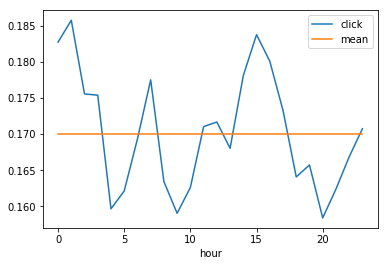

In [18]:
df_hours['mean'] = df['click'].mean()

df_hours.plot()
plt.show()

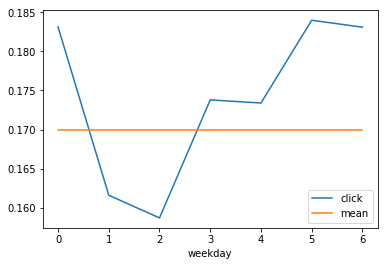

In [19]:
df_weekday['mean'] = df['click'].mean()

df_weekday.plot()
plt.show()

<strong>Additional plots</strong>

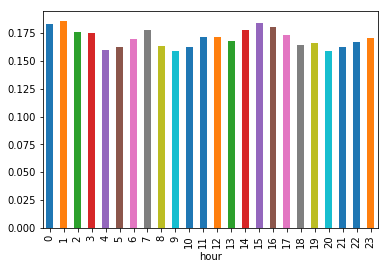

In [20]:
df_hours['click'].plot(kind="bar")
plt.show()

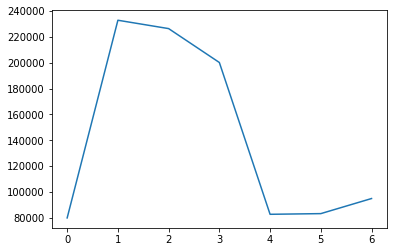

In [21]:
week_plot = df.groupby('weekday')['click'].count()  # Fill here for the influence of the day
plt.plot(week_plot)
plt.show()

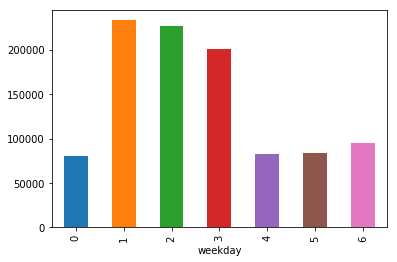

In [22]:
week_plot.plot(kind="bar")
plt.show()

<strong>Hour : </strong> <br>
    X axis represents hours of the day and Y axis the click frequency mean. A significant click rate is noticeable in the morning, around 7 to 9pm, relating to people commuting in public transports and using their phones. The same phenomenon can be observed around the end of the afternoon, for the commute back home. Lastly, there is a 3rd peak in late evening / beginning of the night : it probably represents a more and more common habits of people using their phones in their bed, right before going to sleep.

<strong>Weekday : </strong> <br>
X axis represents the days of the week and Y axis the click frequency mean as well. Here, the distribution seems to be in 2 phases : a strong clickrate phase centered on the week-end, starting at the end of the working week (from Thursdays / Fridays) and finishing on mondays. Then, a weak phase centered on Tuesdays and Wednesdays. Thus, people seem to use their phones a lot more in the week-ends and close to them rather than in the middle of the week. 

# Preliminary work and first model

Start by understanding the features with few modalities:
'hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'.

In [23]:
df_C15 = pd.DataFrame(df.groupby('C15')["click"].mean()) # Fill here: inspect 'C15' using '.groupby'
df_C15.T

C15,120,216,300,320,480,728,768,1024
click,0.033708,0.129612,0.360537,0.158767,0.285714,0.054144,0.375,0.166667


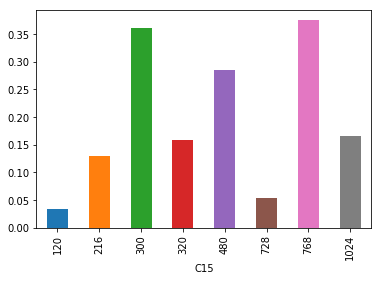

In [24]:
df.groupby('C15')['click'].mean().plot(kind="bar")
plt.show()

In [25]:
df_site_category = pd.DataFrame(df.groupby('site_category')["click"].mean()) # Fill here: inspect 'site_category' using '.groupby'
df_site_category.T 

site_category,0569f928,28905ebd,335d28a8,3e814130,42a36e14,50e219e0,5378d028,70fb0e29,72722551,75fa27f6,...,9ccfa2ea,a818d37a,bcf865d9,c0dd3be3,c706e647,da34532e,dedf689d,e787de0e,f028772b,f66779e6
click,0.053613,0.208076,0.089824,0.284245,0.225806,0.128597,0.0,0.144737,0.059172,0.111305,...,0.0,0.0,0.0,0.128655,0.0,0.0,0.530449,0.0,0.179719,0.034564


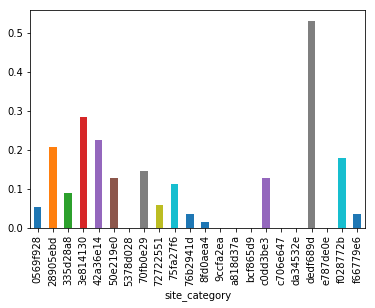

In [26]:
df.groupby('site_category')['click'].mean().plot(kind="bar")
plt.show()

Some site categories have a null click rate. We display the count of each modality

In [27]:
df_q11 = pd.DataFrame(df.groupby('site_category')['click'].value_counts())
df_q11.columns = ['Value Count']
df_q11

Value Count
site_category click             
0569f928      0              406
              1               23
28905ebd      0           144146
              1            37874
335d28a8      0             3050
              1              301
3e814130      0            54159
              1            21508
42a36e14      0               48
              1               14
50e219e0      0           356335
              1            52586
5378d028      0               11
70fb0e29      0              520
              1               88
72722551      0              636
              1               40
75fa27f6      0             3561
              1              446
76b2941d      0             2481
              1               92
8fd0aea4      0              186
              1                3
9ccfa2ea      0                5
a818d37a      0               81
bcf865d9      0               16
c0dd3be3      0              894
              1              132
c706e647      0                1
da34532e      0                1
dedf689d      1              331
              0              293
e787de0e      0               28
f028772b      0           257026
              1            56313
f66779e6      0             6145
              1              220

We can see here that some site categories have a null click rate.

It is practical to visualize both columns in parallel:

In [28]:
col = 'site_category'
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'count']
a.sort_values(by='count', ascending=False).tail(10)

,mean,count
site_category,,
0569f928,0.053613,429.0
8fd0aea4,0.015873,189.0
a818d37a,0.000000,81.0
42a36e14,0.225806,62.0
e787de0e,0.000000,28.0
bcf865d9,0.000000,16.0
5378d028,0.000000,11.0
9ccfa2ea,0.000000,5.0
c706e647,0.000000,1.0


This table shows that the site categories that have a null click rate also have low counts. It means they do not appear much in the dataset and thus the click rate calculated might not be relevant as there is not enough instances of it.

We divide the set into training (90%) and test (10%)

In [29]:
SEED = 100
#df2 = df.copy()
#df2 = df2.drop("id", axis=1)
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    df.iloc[:,2:], df['click'], test_size=0.1, random_state = SEED)

In [30]:
print('Train shape : ' + str(Xtrain.shape))
print('Test shape : ' + str(Xtest.shape))

Train shape : (900000, 23)
Test shape : (100000, 23)


# First work on a reduced number of features

In [31]:
some_columns = ['hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 
                'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21']
slice_df = df[some_columns]

slice_df.head()

,hour,weekday,C1,banner_pos,site_category,app_category,device_type,device_conn_type,C15,C16,C18,C21
0,15,2,1005,1,f028772b,07d7df22,1,2,320,50,2,32
1,7,3,1002,0,50e219e0,07d7df22,0,0,320,50,2,32
2,11,0,1005,0,50e219e0,cef3e649,1,0,320,50,1,71
3,3,2,1005,0,50e219e0,0f2161f8,1,0,320,50,0,221
4,2,2,1005,1,f028772b,07d7df22,1,0,320,50,3,23


In [32]:
####This label encoding is only necessary for sklearn < 0.20 (since one hot encoder handle more categories and negative values in the further versions)
# As some variables are in a hex-like format, we must first encode these labels

from sklearn.preprocessing import LabelEncoder

site_categ_label = LabelEncoder().fit(Xtrain['site_category'])
app_categ_label = LabelEncoder().fit(Xtrain['app_category'])

Xtrain['site_category'] = site_categ_label.transform(Xtrain['site_category'])
Xtrain['app_category'] = app_categ_label.transform(Xtrain['app_category'])
Xtest['site_category'] = site_categ_label.transform(Xtest['site_category'])
Xtest['app_category'] = app_categ_label.transform(Xtest['app_category'])


In [33]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder().fit(Xtrain[some_columns])

Xtrain_oh = ohe.transform(Xtrain[some_columns]) # fit the transformation of Xtrain restricted to selected columns
Xtest_oh = ohe.transform(Xtest[some_columns]) # and transform Xtest restricted to selected columns

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


We encoded the columns, each will have a 0 or a 1 for each different value of the column

In [34]:
print("Number of features :" ,Xtrain_oh.shape[1])

Number of features : 183


We visualize the first row of the design matrix you have got.

In [35]:
Xtrain_oh.toarray()[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

We Import and fit a logistic regression model on our the encoded data

In [36]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = SEED)
lr.fit(Xtrain_oh,ytrain)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=100, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

We display the hard and soft decision you get on test data

In [37]:
hard = lr.predict(Xtest_oh)
pd.DataFrame(hard).T

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
soft = lr.predict_proba(Xtest_oh)
pd.DataFrame(soft).T

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,0.75809,0.733976,0.796909,0.919778,0.750737,0.867929,0.897854,0.871542,0.874921,0.917218,...,0.790397,0.882462,0.858844,0.974004,0.832537,0.853709,0.902483,0.79254,0.785836,0.878487
1,0.24191,0.266024,0.203091,0.080222,0.249263,0.132071,0.102146,0.128458,0.125079,0.082782,...,0.209603,0.117538,0.141156,0.025996,0.167463,0.146291,0.097517,0.20746,0.214164,0.121513


We Compute the probability of **error** using sklearn.metrics 'accuracy_score' function

In [39]:
from sklearn.metrics import accuracy_score
hard_score_selected = accuracy_score(ytest, hard)
print("Hard score ", hard_score_selected)

Hard score  0.83043


The score is 83% : it is a pretty bad score considering there is a 17% click rate. As <i>1 - 0.17 = 0.83</i>, it means it's like if our classifier only predicted everytime no click

We could for instance use balanced_accuracy_score or any other metric using the same arguments

We Plot the ROC curve and compute the log loss and the Area Under the Curve ROC

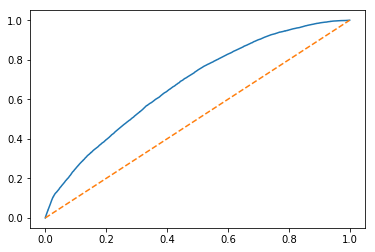

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve
#roc_curve(ytest,soft[:,1])
#plt.plot(roc_curve(ytest,soft[:,1]))

#from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, threshold = roc_curve(ytest,  soft[:,1])
plt.plot(fpr,tpr, '-')
plt.plot([0,1],[0,1], linestyle='--')
plt.show()

In [41]:
from sklearn.metrics import log_loss , roc_auc_score 
log_loss_selected = log_loss(ytest, soft[:,1]), roc_auc_score(ytest, soft[:,1])
print("Log loss : ", log_loss_selected)

Log loss :  (0.42512223391774184, 0.6762765906600234)


In [42]:
roc_feature_selected = roc_auc_score(ytest, soft[:,1])
print("Area under roc curve : ", roc_feature_selected)

Area under roc curve :  0.6762765906600234


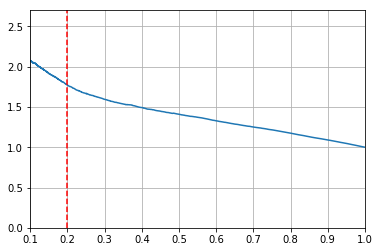

In [43]:
from utils import plotlift
plotlift(ytest, soft[:,1])
# The following line just plots a vertical line for you to answer the second part of the question
plt.axvline(x= 0.2 , linestyle='--', color='r') # Fill here
plt.show()

The lift of the fifth of the population is aproximatly 1.8

It shows that on the first fifth of the population, the model performs at least 1.8 times better than random guess

# Complete model

For each modality, we compute the number of occurrences in the dataset and the average of clicks for this modality 
We represent the set of points (count, mean) for each modality

In [44]:
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


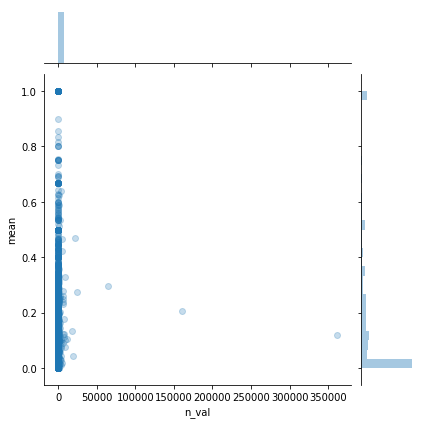

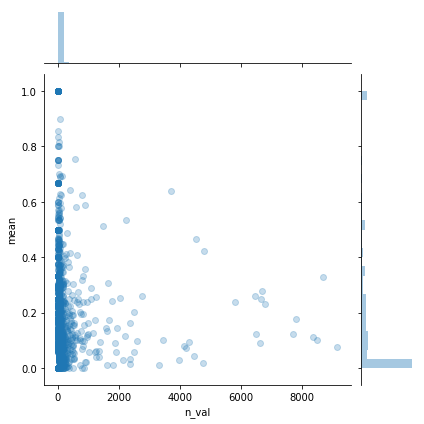

In [45]:
col = 'site_id'
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'n_val']
sns.jointplot(a['n_val'], a['mean'], alpha=0.25)
thres = 10000
sns.jointplot(a[a['n_val']<thres]['n_val'], a[a['n_val']<thres]['mean'], alpha=0.25);

Alpha is the transparency

Several sites with a lot of occurrences in the dataset have a click frequency very different from the mean. It is relevant to keep the column 'site_id' at least for the modalities for which 'count' is very high. We do the same work on the 'device_id' column.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


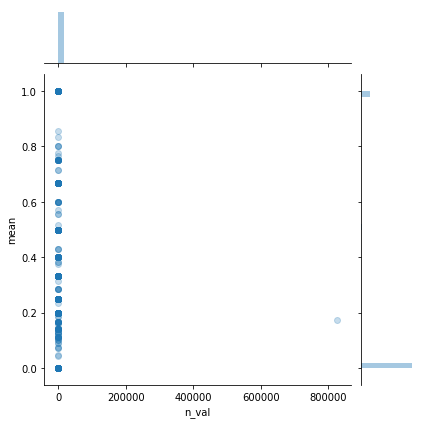

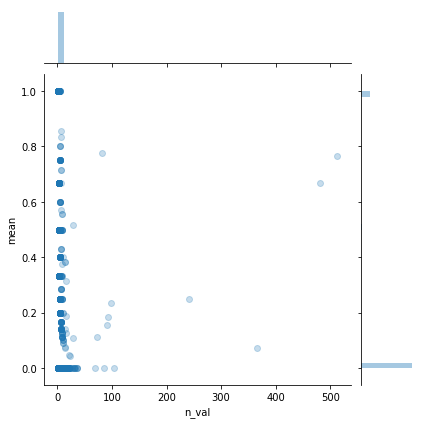

In [46]:
col = 'device_id'
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'n_val']
sns.jointplot(a['n_val'], a['mean'], alpha=0.25);
thres = 10000
sns.jointplot(a[a['n_val']<thres]['n_val'], a[a['n_val']<thres]['mean'], alpha=0.25);

We can see an isolated value on the first plot (X ~ 800000 and Y~ 0.2)

In [47]:
a[a['n_val']>1000]

,mean,n_val
device_id,,
a99f214a,0.174347,824918.0


This isolated point shows that 82% of device have the same id. We haven't found enough data on what those id represent but it might represent all unknown values

We create a new column df['user']
$$
\text{user} = \left\{\begin{array}[h]{ll} \text{device_ip + device_model} & \text{if device_id = V}\\ \text{device_id} & \text{else.}\end{array}\right.
$$

In [48]:
V = pd.DataFrame(df.groupby('device_id').count()['click']).sort_values(by='click', ascending=False).reset_index().iloc[0,0]
V

'a99f214a'

In [49]:
df['user'] = np.where(df['device_id']==V, df['device_ip']+df['device_model'] , df['device_id'])
df['user'].head(10)

0    fb6566d3be87996b
1            9b7af851
2    748e298a3c55fad5
3    a50da3d4c5cc73c1
4    d5f88679a5bce124
5    189590f92ea4f8ba
6            192d98b0
7    342b6e9ea0f5f879
8            50dc7a55
9            feb99a64
Name: user, dtype: object

We drop the following columns: 'device_id','device_model','device_ip'

In [50]:
df = df.drop(['device_id','device_model','device_ip'], axis=1)
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user
0,3.983206e+18,0,15,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,4687,320,50,423,2,39,100148,32,2,fb6566d3be87996b
1,7.756884e+18,0,7,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,...,17894,320,50,2039,2,39,100077,32,3,9b7af851
2,6.941774e+17,0,11,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,...,22684,320,50,2619,1,163,100055,71,0,748e298a3c55fad5
3,2.664154e+18,1,3,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,...,23222,320,50,2676,0,35,100176,221,2,a50da3d4c5cc73c1
4,1.480510e+19,0,2,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,...,8330,320,50,761,3,175,100081,23,2,d5f88679a5bce124


The similarity between 'site_id' and 'site_domain' is important so we merge those columns into a new 'site' column and delete the old 'site_id' and 'site_domain' columns.

In [51]:
df['site'] = np.where(df['site_id']==df['site_domain'], df['site_id'] , df['site_id']+df['site_domain'])
df = df.drop(['site_id','site_domain'], axis=1)

In [52]:
df['site'].head(10)

0    e151e2457e091613
1    cb809abf74acf31a
2    85f751fdc4e18dd6
3    85f751fdc4e18dd6
4    791b5571fd13bc73
5    85f751fdc4e18dd6
6    85f751fdc4e18dd6
7    85f751fdc4e18dd6
8    85f751fdc4e18dd6
9    85f751fdc4e18dd6
Name: site, dtype: object

Once again, split the modified DataFrame df into a train (90%) and a test set (10%)


In [53]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    df.iloc[:,2:], df['click'], test_size=0.1, random_state = SEED)

We define a OneHotEncoder and then, 'fit_transform' the train set

In [54]:
# First we need to define labelEncoders for encoding categorical columns

data = Xtrain.append(Xtest, ignore_index = True, sort = False)

site_categ_label = LabelEncoder().fit(data['site_category'])
app_categ_label = LabelEncoder().fit(data['app_category'])
app_id = LabelEncoder().fit(data['app_id'])
app_domain = LabelEncoder().fit(data['app_domain'])
user_label = LabelEncoder().fit(data['user'])
site_label = LabelEncoder().fit(data['site'])
data['site_category'] = site_categ_label.transform(data['site_category'])
data['app_category'] = app_categ_label.transform(data['app_category'])
data['app_id'] = app_id.transform(data['app_id'])
data['app_domain'] = app_domain.transform(data['app_domain'])
data['user'] = user_label.transform(data['user'])
data['site'] = site_label.transform(data['site'])
data['C20'] = data['C20'].abs()

Xtrain = data.iloc[:Xtrain.shape[0],:]
Xtest = data.iloc[Xtrain.shape[0]:,:]

In [55]:
Xtest.shape

(100000, 20)

NOTE : Here we're using Xtrain & Xtest values to fit the labelEncoders as there are some values in Xtest that are not in Xtrain. We could have used df directly to simply the process, but it wouldn't have made sense in a real situation so we preferred to add both sets into a data variable and work on it

In [56]:


ohe = OneHotEncoder(handle_unknown="ignore").fit(Xtrain)

Xtrain_oh = ohe.transform(Xtrain)



In [57]:


Xtest_oh = ohe.transform(Xtest)

We had to transform / encode a few labels first for the OHE to work

In [58]:
print("Number of features :" ,Xtrain_oh.shape[1])

Number of features : 713334


As we can see, one hot encoding gave us 713334, but only by seing how full the column are, we can detect the one containing most data (here 2552 in that case)

We look at the modalities that have been seen more than a 100 times

In [59]:
# The following 'n_ones' vector below gives the number of '1' in each column/modality of the Xtrain_oh design matrix.
n_ones = np.array(Xtrain_oh.sum(axis=0))
df_ones = pd.DataFrame(n_ones).T
index_100 = df_ones[df_ones[0]>100].index

print(str(len(index_100)), ' modalities have been seen more than a 100 times \n')

print("Columns' index where the sum of 1 is superior of 100 : ")
print(index_100.values)


1971  modalities have been seen more than a 100 times 

Columns' index where the sum of 1 is superior of 100 : 
[     0      1      2 ... 713301 713307 713321]


The list 'cols_to_keep' below is used to store the indices of the modalities seen more than a 100 times.

In [60]:

cols_to_keep = np.argwhere(n_ones>100)[:,1]
print("Index of the column where the sum of 1 is superior of 100", cols_to_keep)


Index of the column where the sum of 1 is superior of 100 [     0      1      2 ... 713301 713307 713321]


As we can see there is only 1971 modalities seen more than 100 times. 
Thats not a lot regarding with the number of datas

Using only our restriction on the 'cols_to_keep' columns, we retrain a logistic regression model and compare its performance in terms of 'log_loss' and 'roc_auc_curve'

In [61]:
Xtrain_oh_filtered = Xtrain_oh[:,cols_to_keep]
Xtest_oh_filtered = Xtest_oh[:,cols_to_keep]

Xtrain_oh.shape

(900000, 713334)

In [62]:
lr = LogisticRegression()
lr.fit(Xtrain_oh_filtered,ytrain)
hard = lr.predict(Xtest_oh_filtered)
soft = lr.predict_proba(Xtest_oh_filtered)

from sklearn.metrics import accuracy_score
hard_score_feature_engin = accuracy_score(ytest, hard)
print("Hard score ", hard_score_feature_engin)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Hard score  0.83375


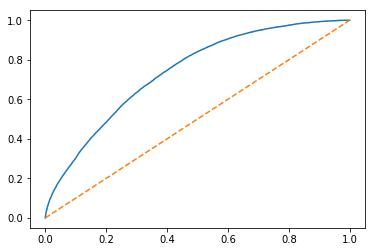

In [63]:
fpr, tpr, threshold = roc_curve(ytest,  soft[:,1])
plt.plot(fpr,tpr, '-')
plt.plot([0,1],[0,1], linestyle='--')
plt.show()

In [64]:
log_loss_feature_engin = log_loss(ytest, soft[:,1]), roc_auc_score(ytest, soft[:,1])
print("Log loss : ", log_loss_feature_engin)

Log loss :  (0.40115170753842516, 0.7385988630146278)


In [65]:
roc_feature_engin = roc_auc_score(ytest, soft[:,1])
print("Area under roc curve : ", roc_feature_engin)

Area under roc curve :  0.7385988630146278


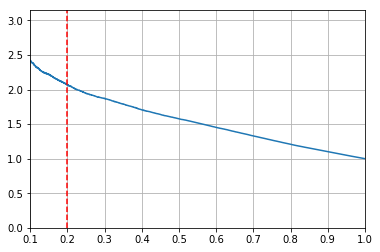

In [66]:
plotlift(ytest, soft[:,1])
plt.axvline(x= 0.2 , linestyle='--', color='r') # Fill here
plt.show()

**Adding our selected features imrpoved our score from 0.83 to 0.83375 => the score is a little bit better but still it is close to predicting full 0**

**The ROC curve is also better, closer to the ideal curve (we can see it because the area under roc curve increased)**

**Has we can see, we improved our lift, it went from 1.8 to 2.1 (approimatly).**

So we did create a better model, but it clan clearly be improved


# Gradient Boosting Decision Trees

We create a GradientBoostingClassifier using 50 estimators and a learning rate of 0.8. We fit it on the same columns 'cols_to_keep' of Xtrain_oh than for the previous logistic regression. We evaluate the performance

In [67]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(verbose=True, learning_rate=0.8, n_estimators=50, random_state = SEED)
%time gb.fit(Xtrain_oh_filtered,ytrain)

hard = gb.predict(Xtest_oh_filtered)
soft = gb.predict_proba(Xtest_oh_filtered)

hard_score_gb = accuracy_score(ytest, hard)
print("Hard score ", hard_score_gb)

      Iter       Train Loss   Remaining Time 
         1           0.8743            6.36m
         2           0.8646            5.80m
         3           0.8583            5.50m
         4           0.8535            5.20m
         5           0.8503            5.07m
         6           0.8464            4.88m
         7           0.8441            4.70m
         8           0.8418            4.55m
         9           0.8404            4.41m
        10           0.8383            4.28m
        20           0.8282            3.25m
        30           0.8234            2.18m
        40           0.8190            1.06m
        50           0.8163            0.00s
Wall time: 5min 14s
Hard score  0.83343


In [68]:
log_loss_gb = log_loss(ytest, soft[:,1])
print("Log loss ", log_loss_gb)

Log loss  0.4091871736006742


In [69]:
roc_gb = roc_auc_score(ytest, soft[:,1])
print("Roc area ", roc_gb)

Roc area  0.7251893509766301


In [70]:
print("Models : ","First colon selected |","Feature selection |", "Gradient Boost")
print("Scores : ",hard_score_selected, "|",hard_score_feature_engin, "|", hard_score_gb)
print("Log loss : ",log_loss_selected, "|",log_loss_feature_engin, "|", log_loss_gb)
print("Roc Area : ",roc_feature_selected, "|",roc_feature_engin, "|", roc_gb)

Models :  First colon selected | Feature selection | Gradient Boost
Scores :  0.83043 | 0.83375 | 0.83343
Log loss :  (0.42512223391774184, 0.6762765906600234) | (0.40115170753842516, 0.7385988630146278) | 0.4091871736006742
Roc Area :  0.6762765906600234 | 0.7385988630146278 | 0.7251893509766301


The gradiant boost model seems less efficient with those parameters than the logistic regression on the feature selected columns 
(area thiner, score also)

In [71]:
gb.estimators_

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x000001CE92FE1090>,
           splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x000001CE92FE1090>,
           splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_

gb_estimators output the parameters of the different model used (here 50). 

We now try to use the 'gb' classifier to generate features that will be relevant inputs for the logistic regression.We generate a transformation 'leafs_train' of the training set 'Xtrain_oh[:, cols_to_keep]' for which the nth column corresponds to the number of the leaf returned by the estimator n

In [72]:
leafs_train = gb.apply(Xtrain_oh_filtered).reshape(Xtrain_oh_filtered.shape[0], 50)
leafs_test = gb.apply(Xtest_oh_filtered).reshape(Xtest_oh_filtered.shape[0], 50)

After your applied gb.apply on Xtrain_oh[:, cols_to_keep], remember that use have only one class to predict (click = 0 or 1). 

In [73]:
print(leafs_test)

[[10.  3.  3. ...  3.  3.  3.]
 [10.  3.  3. ...  3.  3.  3.]
 [ 3.  3.  3. ...  3.  3.  3.]
 ...
 [ 3.  3.  3. ...  3.  3.  3.]
 [ 3.  3.  3. ...  3.  3.  3.]
 [ 3.  3.  3. ...  3.  3.  3.]]


In [74]:
leafs_train = pd.DataFrame(leafs_train) # Fill here
leafs_test = pd.DataFrame(leafs_test)

We encode these new features into dummies

In [75]:
ohe = OneHotEncoder(handle_unknown="ignore").fit(leafs_train) # Fill here an argument if needed
leafs_train_oh = ohe.transform(leafs_train)
leafs_test_oh = ohe.transform(leafs_test)

With the "hstack" function, we create a new matrix of features by concatenating horizontally our new features "leafs_train_oh" and "leafs_test_oh", and previous features used for logistic regression (e.g. in "Xtrain_oh[:, cols_to_keep]")

**Remark**: we use "hstack" from scipy.sparse (and not from numpy) because the output of our OneHotEncoder is a sparse array. You can verify it with the command "type(Xtrain_oh)".

In [76]:
from scipy.sparse import csr_matrix, hstack
Xtrain_concat = hstack([ Xtrain_oh_filtered , leafs_train_oh ]) # Fill here
Xtest_concat = hstack([ Xtest_oh_filtered , leafs_test_oh ])

We run a logistic regression on the new features and evaluate its performance as before

In [77]:
lr = LogisticRegression(random_state = SEED)
lr.fit(Xtrain_concat,ytrain)
hard = lr.predict(Xtest_concat)
soft = lr.predict_proba(Xtest_concat)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [78]:
hard_score_gb_leaf = accuracy_score(ytest, hard)
print("Hard score ", hard_score_gb_leaf)

Hard score  0.83405


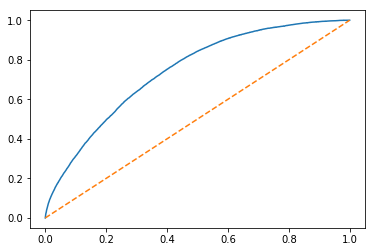

In [79]:
fpr, tpr, threshold = roc_curve(ytest,  soft[:,1])
plt.plot(fpr,tpr, '-')
plt.plot([0,1],[0,1], linestyle='--')
plt.show()


In [80]:
log_loss_gb_leaf = log_loss(ytest, soft[:,1]), roc_auc_score(ytest, soft[:,1])
print("Log loss : ", log_loss_gb_leaf)

Log loss :  (0.3999497071713706, 0.7417438966297424)


In [81]:
roc_gb_leaf = roc_auc_score(ytest, soft[:,1])
print("Area under roc curve : ", roc_gb_leaf)

Area under roc curve :  0.7417438966297424


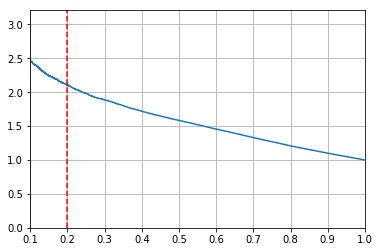

In [82]:
plotlift(ytest, soft[:,1])
plt.axvline(x= 0.2 , linestyle='--', color='r')
plt.show()

In [83]:
print("Models : ","First colon selected |","Feature selection |", "Gradient Boost |", "Gradient Boost leaf|")
print("Scores : ",hard_score_selected, "|",hard_score_feature_engin, "|", hard_score_gb, "|", hard_score_gb_leaf)
print("Log loss : ",log_loss_selected, "|",log_loss_feature_engin, "|", log_loss_gb, "|", log_loss_gb_leaf)
print("Roc Area : ",roc_feature_selected, "|",roc_feature_engin, "|", roc_gb, "|", roc_gb_leaf)

Models :  First colon selected | Feature selection | Gradient Boost | Gradient Boost leaf|
Scores :  0.83043 | 0.83375 | 0.83343 | 0.83405
Log loss :  (0.42512223391774184, 0.6762765906600234) | (0.40115170753842516, 0.7385988630146278) | 0.4091871736006742 | (0.3999497071713706, 0.7417438966297424)
Roc Area :  0.6762765906600234 | 0.7385988630146278 | 0.7251893509766301 | 0.7417438966297424


**Adding those features improved our model, we came from a model weeker than GB but now we have a model predicting better  than GB (looking at score or area under ROC curve)**

We create an XGBClassifier and initialize it using the same number of estimators and learning rate as before. We fit it on the same columns 'cols_to_keep' of Xtrain_oh than for the previous logistic regression.
    <br>
    - Evaluate its performance and compare it to the GradientBoosting classifier of scikit learn. How is the error? Does it take more time to run?
</font>

In [84]:
from xgboost import XGBClassifier
xgb = XGBClassifier(verbose=True, learning_rate=0.8, n_estimators=50, random_state = SEED, n_jobs=-1)
%time xgb.fit(Xtrain_concat,ytrain)

hard = xgb.predict(Xtest_concat)
soft = xgb.predict_proba(Xtest_concat)

hard_score_xgb = accuracy_score(ytest, hard)
print("Hard score ", hard_score_xgb)


Wall time: 1min 34s
Hard score  0.83348


In [85]:
log_loss_xgb = log_loss(ytest, soft[:,1])
print("Log loss ", log_loss_xgb)

Log loss  0.4062316573063936


In [86]:
roc_xgb = roc_auc_score(ytest, soft[:,1])
print("Roc area ", roc_xgb)


Roc area  0.7290316623949777


In [87]:
print("Models : ","First colon selected |","Feature selection |", "Gradient Boost |", "Gradient Boost leaf|","XGB")
print("Scores : ",hard_score_selected, "|",hard_score_feature_engin, "|", hard_score_gb, "|", hard_score_gb_leaf,"|", hard_score_xgb)
print("Log loss : ",log_loss_selected, "|",log_loss_feature_engin, "|", log_loss_gb, "|", log_loss_gb_leaf,"|", log_loss_xgb)
print("Roc Area : ",roc_feature_selected, "|",roc_feature_engin, "|", roc_gb, "|", roc_gb_leaf,"|", roc_xgb)

Models :  First colon selected | Feature selection | Gradient Boost | Gradient Boost leaf| XGB
Scores :  0.83043 | 0.83375 | 0.83343 | 0.83405 | 0.83348
Log loss :  (0.42512223391774184, 0.6762765906600234) | (0.40115170753842516, 0.7385988630146278) | 0.4091871736006742 | (0.3999497071713706, 0.7417438966297424) | 0.4062316573063936
Roc Area :  0.6762765906600234 | 0.7385988630146278 | 0.7251893509766301 | 0.7417438966297424 | 0.7290316623949777


**We chose n_jobs = -1 to parallelize our computation, it means use all available ressources (cores) => It gives us a model faster to fit and predict.**

**This new model is a little bit weaker than the gradiant boost associated with the logistic regression but better than the Gb alone (thin difference) regarding to ROC and score**


We increase the number of estimators and visualize the impact on performance

In [88]:
from xgboost import XGBClassifier
xgb2 = XGBClassifier(verbose=True, learning_rate=1, n_estimators=1024, random_state = SEED, n_jobs=-1)
%time xgb2.fit(Xtrain_concat,ytrain)

hard = xgb2.predict(Xtest_concat)
soft = xgb2.predict_proba(Xtest_concat)

hard_score_xgb2 = accuracy_score(ytest, hard)
print("Hard score ", hard_score_xgb2)

Wall time: 28min 22s
Hard score  0.83288


In [89]:
log_loss_xgb2 = log_loss(ytest, soft[:,1])
print("Log loss ", log_loss_xgb2)

Log loss  0.40079399106913244


In [90]:
roc_xgb2 = roc_auc_score(ytest, soft[:,1])
print("Roc area ", roc_xgb2)

Roc area  0.7421910171049341


In [91]:
print("Models : ","First colon selected |","Feature selection |", "Gradient Boost |", "Gradient Boost leaf|","XGB","XGB 1024")
print("Scores : ",hard_score_selected, "|",hard_score_feature_engin, "|", hard_score_gb, "|", hard_score_gb_leaf,"|", hard_score_xgb,"|", hard_score_xgb2)
print("Log loss : ",log_loss_selected, "|",log_loss_feature_engin, "|", log_loss_gb, "|", log_loss_gb_leaf,"|", log_loss_xgb,"|", log_loss_xgb2)
print("Roc Area : ",roc_feature_selected, "|",roc_feature_engin, "|", roc_gb, "|", roc_gb_leaf,"|", roc_xgb,"|", roc_xgb2)

Models :  First colon selected | Feature selection | Gradient Boost | Gradient Boost leaf| XGB XGB 1024
Scores :  0.83043 | 0.83375 | 0.83343 | 0.83405 | 0.83348 | 0.83288
Log loss :  (0.42512223391774184, 0.6762765906600234) | (0.40115170753842516, 0.7385988630146278) | 0.4091871736006742 | (0.3999497071713706, 0.7417438966297424) | 0.4062316573063936 | 0.40079399106913244
Roc Area :  0.6762765906600234 | 0.7385988630146278 | 0.7251893509766301 | 0.7417438966297424 | 0.7290316623949777 | 0.7421910171049341


**The ROC curve is the best of all the models, but the score is the worst. Maybe the way of scoring is not the most apropriate.**

**The time taken by the model is aproximatly 16m which is a lot more than the others**

# Features hashing and random forest

We restart with raw features before dummy encoding: Xtrain, Xtest.
<font color="red">**Question 43**:
    Display again the number of modalities per feature in Xtrain.
</font>

In [92]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    df.iloc[:,2:], df['click'], test_size=0.1, random_state = SEED)

In [93]:
print("Number of different element for each feature in Xtrain : \n", Xtrain.nunique())

Number of different element for each feature in Xtrain : 
 hour                    24
C1                       7
banner_pos               7
site_category           22
app_id                3054
app_domain             196
app_category            26
device_type              5
device_conn_type         4
C14                   2225
C15                      8
C16                      9
C17                    420
C18                      4
C19                     66
C20                    163
C21                     60
weekday                  7
user                701585
site                  5442
dtype: int64


In [94]:
print("Number of different element for each feature in Xtest : \n", Xtest.nunique())

Number of different element for each feature in Xtest : 
 hour                   24
C1                      7
banner_pos              7
site_category          19
app_id               1308
app_domain             91
app_category           19
device_type             4
device_conn_type        4
C14                  1733
C15                     8
C16                     9
C17                   400
C18                     4
C19                    64
C20                   157
C21                    60
weekday                 7
user                91546
site                 2199
dtype: int64


We want to define a transformation which regroups the least frequent modalities into a label 'isRare'. In order to do so, we decide to define our own Transformer.


In [95]:
from sklearn.base import BaseEstimator, TransformerMixin

class MergeRareTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, col_names, threshold):
        self.col_names = col_names
        self.threshold = threshold

    def fit(self, X, y=None):

        X = pd.DataFrame(X)
        counts_dict_list = []
        ################## READ THIS #########################
        for i in range(len(self.col_names)):
            
            serie = X[self.col_names[i]].value_counts()  # Série des counts de chaque modalité
            rare_indexes = serie[serie<self.threshold[i]].index  # A quoi correspondent ces indices ?
            frequent_indexes = serie[serie>=self.threshold[i]].index  # A quoi correspondent ces indices ?
            dico = {x:'isRare' for x in rare_indexes}
            dico.update({x: str(x) for x in frequent_indexes})
            counts_dict_list.append(dico)   # Quel est le dictionnaire obtenu ?
            
        ######################################################
            
        self.counts_dict_list_ = counts_dict_list
        return self

    def transform(self, X):

        Xt = pd.DataFrame()
        ################## READ THIS #########################
        for col, count_dict in zip(self.col_names, self.counts_dict_list_):
            Xt[col] = X[col].apply(lambda x:count_dict[x] if x in count_dict else 'isRare')
            # A quoi sert le "else 'isRare'" dans la transformation de la colonne ?
        ######################################################

        return Xt


**Fit**

rare_indexes : Contains the index of the count of values inferior to the thresold 

frequent_indexes : Contains the index of the count of values superior to the thresold

counts_dict_list : The dictionary will contain either (key:value):

    *index : 'isRare' if the value was selected as rare (value count < threshold)
    
    *index : 'index' (string version of index) if the value was selected as frequent (value count >= threshold)
    
    => So the dict has index : str(index) for the frequent values and index:'isRare' for the rare

**Transform**

The else case is here in the case the value is not in the dictionary (which has been fited before), so it means it's a rare value
    



We fit and transform the training set. To do so, we merge all mmodalities occuring at least 20 times in each column

In [96]:
mg = MergeRareTransformer(col_names=Xtrain.columns, threshold=[20]*len(Xtrain.columns))
Xtrain_mg = mg.fit_transform(Xtrain) # Fill here with fit_transform or fit then transform.
Xtest_mg = mg.transform(Xtest)

In [97]:
nb_rare_app_domain = Xtrain_mg[Xtrain_mg['app_domain'] == 'isRare'].shape[0]
print("Number of lines labelled as rare in the app domain column ",nb_rare_app_domain)

Number of lines labelled as rare in the app domain column  513


**There is 513 out of 100000 values which occurs less than 400 times (20*20)**

In [98]:
nb_modalities_features = Xtrain_mg.nunique()
print("The number of different modalities per features is (minus one because of the rare values) : \n", nb_modalities_features)

The number of different modalities per features is (minus one because of the rare values) : 
 hour                  24
C1                     7
banner_pos             7
site_category         18
app_id               613
app_domain            53
app_category          19
device_type            5
device_conn_type       4
C14                 1339
C15                    8
C16                    9
C17                  381
C18                    4
C19                   63
C20                  148
C21                   60
weekday                7
user                 901
site                 889
dtype: int64


Modalities are arbitrary object, such as '234', 'isRare', etc. We will now transorm them into integers with the hashing trick.

In [99]:
import hashlib
hash("TEST") # Fill here

-1225165818692003710

**A Hashing function use most of the time an injective function (we cannot come back from the hashed value to the original one) generating a value of always the same size. It is often used in security (store password on a server from instance where you compare the value hash of the pass entered by the user to the hash stored in database). Here the hash seem to generate an int value**

We create two new datasets 'Xtrain_ha' and 'Xtest_ha' containing the output of the hashing process. We use the '.apply' method to transform iteratively the columns by mapping to each value its remainder in the euclidean division of the hash by 1000000. 
   Example:
</font>
</font>
<p>
<center>
2060777048690<font color="red">918393</font>  -->  918393
</center>


In [100]:
Xtrain_ha = pd.DataFrame()
Xtest_ha = pd.DataFrame()
for col in Xtrain_mg.columns:
    Xtrain_ha[col] = Xtrain_mg[col].apply(lambda x : hash(x)%1000000) # Fill here defining a lambda function
    Xtest_ha[col] = Xtest_mg[col].apply(lambda x : hash(x)%1000000)

In [101]:
Xtrain_ha

,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
92438,44288,645197,941907,190736,837441,598121,928731,133772,261207,68320,584181,378279,389313,903891,668266,932701,414379,903891,719606,199424
60898,327813,469083,903891,190736,76917,32478,518219,941907,134812,68320,584181,378279,389313,903891,668266,932701,414379,941907,719606,199424
556199,133772,469083,903891,157555,773403,598121,540635,941907,134812,923418,584181,378279,446638,903891,259803,932701,665514,903891,719606,234351
193129,158456,469083,941907,157555,773403,598121,540635,941907,903891,968396,584181,378279,211159,903891,244406,392640,839870,941907,719606,837701
231985,568286,469083,903891,604470,773403,598121,540635,941907,903891,649118,584181,378279,389313,903891,668266,652113,414379,714156,719606,867922
235945,261207,469083,941907,157555,773403,598121,540635,941907,903891,509437,584181,378279,929015,134812,186166,932701,957634,133772,719606,380097
622676,609601,469083,903891,604470,773403,598121,540635,941907,903891,674754,584181,378279,389313,903891,668266,652113,414379,134812,719606,867922
426950,987327,469083,903891,348539,773403,598121,540635,941907,903891,124517,584181,378279,177171,261207,905902,392640,757043,136140,719606,134838
115855,941907,469083,941907,157555,773403,598121,540635,941907,903891,989866,584181,378279,422928,903891,578261,932701,405133,134812,719606,234182
594467,977862,469083,903891,604470,773403,598121,540635,941907,903891,649118,584181,378279,389313,903891,668266,652113,414379,903891,719606,867922


In [102]:
Xtest_ha

,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
617759,714156,469083,941907,157555,773403,598121,540635,941907,903891,333512,584181,378279,40450,134812,578261,932701,518078,261207,719606,967825
693227,44288,469083,903891,604470,773403,598121,540635,941907,903891,607000,584181,378279,303126,134812,726020,989498,89115,134812,719606,34346
906065,609601,469083,941907,157555,773403,598121,540635,941907,903891,947691,584181,378279,60423,261207,668266,98502,568286,136140,719606,837701
828507,714156,469083,903891,190736,685072,32478,928731,941907,903891,269471,584181,378279,842645,261207,724151,311712,996529,261207,719606,199424
869730,44288,309554,903891,190736,773403,598121,540635,903891,903891,978560,584181,378279,741870,134812,578261,932701,518078,134812,719606,421699
147081,609601,469083,941907,157555,773403,598121,540635,941907,903891,731118,584181,378279,707477,261207,842317,921308,12011,714156,719606,459000
779428,987327,469083,903891,190736,153981,645505,928731,941907,134812,750053,584181,378279,652935,903891,668266,932701,313311,134812,719606,199424
485973,136140,469083,903891,157555,773403,598121,540635,941907,903891,477462,584181,378279,703839,903891,668266,6427,405133,134812,719606,894576
30697,731720,469083,941907,157555,773403,598121,540635,941907,903891,172967,584181,378279,707477,261207,842317,921308,12011,714156,719606,967825
306669,44288,469083,903891,190736,918674,32478,213626,941907,134812,445294,584181,378279,100045,903891,933942,706920,839870,261207,719606,199424


We train a RandomForestClassifier on Xtrain_ha and evaluate its performance on Xtest_ha

In [103]:
from sklearn.ensemble import RandomForestClassifier # Fill here
rf = RandomForestClassifier(n_jobs = -1, n_estimators = 1024, min_samples_leaf=20, verbose=1, random_state=SEED)
rf.fit(Xtrain_ha,ytrain)

hard = rf.predict(Xtest_ha)
soft = rf.predict_proba(Xtest_ha)

hard_score_rf = accuracy_score(ytest, hard)
print("Hard score ", hard_score_rf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed: 28.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 1024 out of 1024 | elapsed:   10.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.1s


Hard score  0.83372


[Parallel(n_jobs=4)]: Done 1024 out of 1024 | elapsed:   12.0s finished


In [104]:
log_loss_rf = log_loss(ytest, soft[:,1])
print("Log loss ", log_loss_rf)

Log loss  0.4009500704464555


In [105]:
roc_rf = roc_auc_score(ytest, soft[:,1])
print("Roc area ", roc_rf)


Roc area  0.7410267271275948


In [106]:
print("Models : ","First colon selected |","Feature selection |", "Gradient Boost |", "Gradient Boost leaf|","XGB","XGB 1024|","RF")
print("Scores : ",hard_score_selected, "|",hard_score_feature_engin, "|", hard_score_gb, "|", hard_score_gb_leaf,"|", hard_score_xgb,"|", hard_score_xgb2,"|", hard_score_rf)
print("Log loss : ",log_loss_selected, "|",log_loss_feature_engin, "|", log_loss_gb, "|", log_loss_gb_leaf,"|", log_loss_xgb,"|", log_loss_xgb2,"|", log_loss_rf)
print("Roc Area : ",roc_feature_selected, "|",roc_feature_engin, "|", roc_gb, "|", roc_gb_leaf,"|", roc_xgb,"|", roc_xgb2,"|", roc_rf)

Models :  First colon selected | Feature selection | Gradient Boost | Gradient Boost leaf| XGB XGB 1024| RF
Scores :  0.83043 | 0.83375 | 0.83343 | 0.83405 | 0.83348 | 0.83288 | 0.83372
Log loss :  (0.42512223391774184, 0.6762765906600234) | (0.40115170753842516, 0.7385988630146278) | 0.4091871736006742 | (0.3999497071713706, 0.7417438966297424) | 0.4062316573063936 | 0.40079399106913244 | 0.4009500704464555
Roc Area :  0.6762765906600234 | 0.7385988630146278 | 0.7251893509766301 | 0.7417438966297424 | 0.7290316623949777 | 0.7421910171049341 | 0.7410267271275948


The results are close than those random forest and xgboost gave on the last set of features, yet the Random Forest perform a bit weeker than those 2

We compare with xgboost performance on the same hashed dataset

In [107]:
xgb_hash = XGBClassifier(verbose=True, learning_rate=1, n_estimators=1024, random_state = SEED, n_jobs=-1)

%time xgb_hash.fit(Xtrain_concat,ytrain)# the '%time' command will return the execution time of the fitting step

hard = xgb_hash.predict(Xtest_concat)
soft = xgb_hash.predict_proba(Xtest_concat)

hard_score_xgb_hash = accuracy_score(ytest, hard)
print("Hard score ", hard_score_xgb_hash)

Wall time: 19min 20s
Hard score  0.83288


In [108]:
log_loss_xgb_hash = log_loss(ytest, soft[:,1])
print("Log loss ", log_loss_xgb_hash)

Log loss  0.40079399106913244


In [109]:
roc_xgb_hash = roc_auc_score(ytest, soft[:,1])
print("Roc area ", roc_xgb_hash)


Roc area  0.7421910171049341


In [110]:
print("Models : ","First colon selected |","Feature selection |", "Gradient Boost |", "Gradient Boost leaf|","XGB","XGB 1024","RF","XGB hash")
print("Scores : ",hard_score_selected, "|",hard_score_feature_engin, "|", hard_score_gb, "|", hard_score_gb_leaf,"|", hard_score_xgb,"|", hard_score_xgb2,"|", hard_score_rf,"|", hard_score_xgb_hash)
print("Log loss : ",log_loss_selected, "|",log_loss_feature_engin, "|", log_loss_gb, "|", log_loss_gb_leaf,"|", log_loss_xgb,"|", log_loss_xgb2,"|", log_loss_rf,"|", log_loss_xgb_hash)
print("Roc Area : ",roc_feature_selected, "|",roc_feature_engin, "|", roc_gb, "|", roc_gb_leaf,"|", roc_xgb,"|", roc_xgb2,"|", roc_rf,"|", roc_xgb_hash)

Models :  First colon selected | Feature selection | Gradient Boost | Gradient Boost leaf| XGB XGB 1024 RF XGB hash
Scores :  0.83043 | 0.83375 | 0.83343 | 0.83405 | 0.83348 | 0.83288 | 0.83372 | 0.83288
Log loss :  (0.42512223391774184, 0.6762765906600234) | (0.40115170753842516, 0.7385988630146278) | 0.4091871736006742 | (0.3999497071713706, 0.7417438966297424) | 0.4062316573063936 | 0.40079399106913244 | 0.4009500704464555 | 0.40079399106913244
Roc Area :  0.6762765906600234 | 0.7385988630146278 | 0.7251893509766301 | 0.7417438966297424 | 0.7290316623949777 | 0.7421910171049341 | 0.7410267271275948 | 0.7421910171049341


This model is equivalent in terms of the differents scores than the xgboost we tried on the last set of features, both ranking at the first place as of now

We plot the ROC and the lift curves for the obtained classifier (xgboost on hashed data)

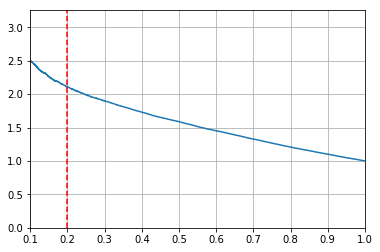

In [111]:
# Plot the lift curve here
plotlift(ytest, soft[:,1])
plt.axvline(x= 0.2 , linestyle='--', color='r')

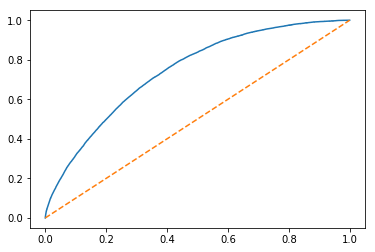

In [112]:
# Plot the ROC curve here
fpr, tpr, threshold = roc_curve(ytest,  soft[:,1])
plt.plot(fpr,tpr, '-')
plt.plot([0,1],[0,1], linestyle='--')
plt.show()

Hashing produces columns of integers arbitrarily ordered. One can wonder if adding more columns hashed in a different fashion would lead to better performance. 
We add hashed columns by recursively hashing the previous ones: complete the following code

In [113]:
Xtrain_haha = pd.DataFrame(Xtrain_ha).copy()
Xtest_haha = pd.DataFrame(Xtest_ha).copy()

n_hash = 3
cols = Xtrain_ha.columns
for l in range(n_hash):
    for col in cols:
        Xtrain_haha[col + '-hash'] = Xtrain_haha[col].apply(lambda x: hash(x)%1000000)
        Xtest_haha[col + '-hash'] = Xtest_haha[col].apply(lambda x: hash(x)%1000000)
    cols = [col + '-hash' for col in cols]

We evaluate the performance of a random forest and/or an xgboost clasifier on these enlarged dataset

In [114]:
rf2 = RandomForestClassifier(n_jobs = -1, n_estimators = 1024, min_samples_leaf=20, verbose=1, random_state=SEED)
rf2.fit(Xtrain_haha,ytrain)

hard = rf2.predict(Xtest_haha)
soft = rf2.predict_proba(Xtest_haha)

hard_score_rf2 = accuracy_score(ytest, hard)
print("Hard score ", hard_score_rf2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed: 55.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   25.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   43.5s
[Parallel(n_jobs=4)]: Done 1024 out of 1024 | elapsed:   58.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    9.9s


Hard score  0.8341


In [115]:
log_loss_rf2 = log_loss(ytest, soft[:,1])
print("Log loss ", log_loss_rf2)

Log loss  0.3999108112025728


In [116]:
roc_rf2 = roc_auc_score(ytest, soft[:,1])
print("Roc area ", roc_rf2)


Roc area  0.742395264461333


In [117]:
print("Models : ","First colon selected |","Feature selection |", "Gradient Boost |", "Gradient Boost leaf|","XGB|","XGB 1024|","RF|","RF Enlarged")
print("Scores : ",hard_score_selected, "|",hard_score_feature_engin, "|", hard_score_gb, "|", hard_score_gb_leaf,"|", hard_score_xgb,"|", hard_score_xgb2,"|", hard_score_rf,"|", hard_score_rf2)
print("Log loss : ",log_loss_selected, "|",log_loss_feature_engin, "|", log_loss_gb, "|", log_loss_gb_leaf,"|", log_loss_xgb,"|", log_loss_xgb2,"|", log_loss_rf,"|", log_loss_rf2)
print("Roc Area : ",roc_feature_selected, "|",roc_feature_engin, "|", roc_gb, "|", roc_gb_leaf,"|", roc_xgb,"|", roc_xgb2,"|", roc_rf,"|", roc_rf2)

Models :  First colon selected | Feature selection | Gradient Boost | Gradient Boost leaf| XGB| XGB 1024| RF| RF Enlarged
Scores :  0.83043 | 0.83375 | 0.83343 | 0.83405 | 0.83348 | 0.83288 | 0.83372 | 0.8341
Log loss :  (0.42512223391774184, 0.6762765906600234) | (0.40115170753842516, 0.7385988630146278) | 0.4091871736006742 | (0.3999497071713706, 0.7417438966297424) | 0.4062316573063936 | 0.40079399106913244 | 0.4009500704464555 | 0.3999108112025728
Roc Area :  0.6762765906600234 | 0.7385988630146278 | 0.7251893509766301 | 0.7417438966297424 | 0.7290316623949777 | 0.7421910171049341 | 0.7410267271275948 | 0.742395264461333


**The RF on the enlarged dataset gave us the best result amongh them all (loss, accuracy, 2nd best ROC Area). Hashing recursively the data 4 times helped us to to create features more usefull for our classifier.**

All in all, it seems the last set of features on the enlarged dataset, hashing recursively the data, gave us the most optimised model. At each step, we learned something on the dataset, which allowed us to improve each time

# Field-aware Factorization Machines


In [119]:
print(Xtrain_ha.columns)

Index(['hour', 'C1', 'banner_pos', 'site_category', 'app_id', 'app_domain',
       'app_category', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'weekday', 'user', 'site'],
      dtype='object')


We create lists of columns

In [128]:
fields = []
fields.append( ['hour','weekday'] )
fields.append( ['site','site_category','banner_pos'] )
fields.append( ['app_id','app_domain','app_category'] )
fields.append( ['device_type','device_conn_type'] )
fields.append( ['C1','C14','C15','C16','C17','C18','C19','C20','C21'] )
fields.append( ['user'] )



We generate a diictionary of the name of each column associated with the content

In [129]:
dicFields = { name_col : f  for i,f in enumerate(fields) for name_col in f}

To format the data in LibFFM format, we must ensure that two different columns have different modalities. To do this, we add before each modality a character string characteristic of the column.
<center>
x --> 'name of column ' + str(x)
</center>


In [130]:
Xtrain_ffm = pd.DataFrame()
Xtest_ffm = pd.DataFrame()
for col in Xtrain_ha.columns:
    Xtrain_ffm[col] = Xtrain_ha[col].apply( lambda x:  col + str(x) )
    Xtest_ffm[col] = Xtest_ha[col].apply( lambda x: col + str(x) )

We create a list of all the categories apearing in our columns

In [131]:
allvals = []
allcols_ffm = [col for f in fields for col in f]  # Toutes les colonnes appartenant à l'un des champ
for col in allcols_ffm:
    allvals.append(np.unique(Xtrain_ffm[col]))
allvals= [val for sublist in allvals for val in sublist]

We create a dictionary associating each value to hist rank in the list of values

In [132]:
dicFeat = {val:i for i,val in enumerate(allvals) }

In each column "col" the value "x" is replaced by "f:v:1" where f is the field associated to the column and v the index of the modality x

In [133]:
for col in allcols_ffm:
    f = dicFields[col]
    Xtrain_ffm[col] = Xtrain_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")
    Xtest_ffm[col] = Xtest_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")

We concatenate our click column

In [136]:
yXtrain_ffm = pd.concat( [ytrain, Xtrain_ffm] ,axis=1)
yXtest_ffm = pd.concat( [ytest, Xtest_ffm] ,axis=1)

In [139]:
train_w = yXtrain_ffm.apply(lambda row: ' '.join(str(row.values)),axis=1).values
test_w = yXtest_ffm.apply(lambda row: ' '.join(str(row.values)),axis=1).values

We concatenate the features with spaces between them

We create a file from our dataframes

In [140]:
thefile = open('train.txt','w')
for item in train_w:
    thefile.write("%s\n" % item)
    
thefile2 = open('test.txt','w')
for item in test_w:
    thefile2.write("%s\n" % item)



To learn the FFM model, use the LibFFM library https://www.csie.ntu.edu.tw/~cjlin/libffm/  
In the notebook/ directory are two executables: ffm-train and ffm-predict.  
In jupyter notebook, the exclamation mark ! allows you to run a bash command.  
The use is as follows: 

-   `ffm-train'

    usage: ffm-train [options] training_set_file [model_file]

    options:  
    -l <lambda>: set regularization parameter (default 0.00002)  
    -k <factor>: set number of latent factors (default 4)  
    -t <iteration>: set number of iterations (default 15)  
    -r <eta>: set learning rate (default 0.2)  
    -s <nr_threads>: set number of threads (default 1)  
    -p <path>: set path to the validation set  
    --quiet: quiet model (no output)  
    --no-norm: disable instance-wise normalization  
    --auto-stop: stop at the iteration that achieves the best validation loss (must be used with -p)  
<br>


We use th ffm library

In [145]:
!./ffm-train -l 0.00001 -r 0.05 -k 15 -t 30 -p ./test.txt --autostop ./train.txt ./model_ffm

'.' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


We compute the log loss and the ROC area under the curve

In [ ]:
hard = model_ffm.predict(Xtest_ffm)
soft = model_ffm.predict_proba(Xtest_ffm)

In [ ]:
hard_score_ffm = accuracy_score(ytest, hard)
print("Hard score ", hard_score_ffm)

In [ ]:
fpr, tpr, threshold = roc_curve(ytest,  soft[:,1])
plt.plot(fpr,tpr, '-')
plt.plot([0,1],[0,1], linestyle='--')
plt.show()


In [ ]:
log_loss_ffm = log_loss(ytest, soft[:,1]), roc_auc_score(ytest, soft[:,1])
print("Log loss : ", log_loss_ffm)

In [ ]:
roc_ffm = roc_auc_score(ytest, soft[:,1])
print("Area under roc curve : ", roc_ffm)